# Introduction to Telstra competition


This is the dataset that is used in the Telstra Network Disruptions competition that ran between Nov 2015 and Feb 2016
This competition provided a very nice and small dataset that allows many aspects of predictive modelling:

* relational data between different entities of the disruption data
* clean dataset that provides consistent and reliable feedback
* ideal for practices for many parts of the predictive modelling pipelin: feature engineering, cross-validation, stacking, etc
* Magic Feature! see forum thread for more details :)
* This dataset is re-uploaded since the original competition did not feature kernels, and it is made available here give people a chance to practice their data science/predictive modelling skill with this nice little dataset

# content




* The goal of the problem is to predict Telstra network's fault severity at a time at a particular location based on the log data available. Each row in the main dataset (train.csv, test.csv) represents a location and a time point. They are identified by the "id" column, which is the key "id" used in other data files.

* Fault severity has 3 categories: 0,1,2 (0 meaning no fault, 1 meaning only a few, and 2 meaning many).

* Different types of features are extracted from log files and other sources: eventtype.csv, logfeature.csv, resourcetype.csv, severitytype.csv.

* Note: “severitytype” is a feature extracted from the log files (in severitytype.csv). Often this is a severity type of a warning message coming from the log. "severitytype" is categorical. It does not have an ordering. “faultseverity” is a measurement of actual reported faults from users of the network and is the target variable (in train.csv).

In [1]:
# Load the libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf                      # to allow RNN and LSTM models
%matplotlib inline

# Load the data

In [2]:
event_type = pd.read_csv('event_type.csv')
log_feature = pd.read_csv('log_feature.csv')
resource_type = pd.read_csv('resource_type.csv')
sample_submission = pd.read_csv('sample_submission.csv')
severity_type = pd.read_csv('severity_type.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
event_type.head()

,id,event_type
0,6597,event_type 11
1,8011,event_type 15
2,2597,event_type 15
3,5022,event_type 15
4,5022,event_type 11


In [4]:
log_feature.head()

,id,log_feature,volume
0,6597,feature 68,6
1,8011,feature 68,7
2,2597,feature 68,1
3,5022,feature 172,2
4,5022,feature 56,1


In [5]:
resource_type.head()

,id,resource_type
0,6597,resource_type 8
1,8011,resource_type 8
2,2597,resource_type 8
3,5022,resource_type 8
4,6852,resource_type 8


In [6]:
sample_submission.head()

,id,predict_0,predict_1,predict_2
0,11066,0,1,0
1,18000,0,1,0
2,16964,0,1,0
3,4795,0,1,0
4,3392,0,1,0


In [7]:
severity_type.head()

,id,severity_type
0,6597,severity_type 2
1,8011,severity_type 2
2,2597,severity_type 2
3,5022,severity_type 1
4,6852,severity_type 1


# 1. Lets do Exploratory data analysis ( EDA )

## analyse Train set

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7381 entries, 0 to 7380
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              7381 non-null   int64 
 1   location        7381 non-null   object
 2   fault_severity  7381 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 173.1+ KB


In [9]:
train.head()

,id,location,fault_severity
0,14121,location 118,1
1,9320,location 91,0
2,14394,location 152,1
3,8218,location 931,1
4,14804,location 120,0


In [10]:
len(train.index)

7381

In [11]:
len(train.id.unique())

7381

In [12]:
len(train.location.unique())

929

In [13]:
len(train.fault_severity.unique())

3

In [14]:
train.isnull().sum()

id                0
location          0
fault_severity    0
dtype: int64

## Analysis Test set

In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11171 entries, 0 to 11170
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        11171 non-null  int64 
 1   location  11171 non-null  object
dtypes: int64(1), object(1)
memory usage: 174.7+ KB


In [16]:
test.head()

,id,location
0,11066,location 481
1,18000,location 962
2,16964,location 491
3,4795,location 532
4,3392,location 600


In [17]:
len(test.index)

11171

In [18]:
len(test.id.unique())

11171

In [19]:
len(test.location.unique())

1039

In [20]:
test.isnull().sum()

id          0
location    0
dtype: int64

# combining training and test data into a single data set

In [21]:
# creating a colum of istrain in both train and test data

train['istrain'] = 1
test['istrain'] = 0

data = train.append(test)

# analysis data

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18552 entries, 0 to 11170
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              18552 non-null  int64  
 1   location        18552 non-null  object 
 2   fault_severity  7381 non-null   float64
 3   istrain         18552 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 724.7+ KB


In [23]:
data.head()

,id,location,fault_severity,istrain
0,14121,location 118,1.0,1
1,9320,location 91,0.0,1
2,14394,location 152,1.0,1
3,8218,location 931,1.0,1
4,14804,location 120,0.0,1


In [24]:
print('total number of rows in data: ' , len(data.index))
print('number of unique id :' , len(data.id.unique()))
print('number of unique locations:' , len(data.location.unique()))
print('number of unique fault severity:' , len(data.fault_severity.unique()))

total number of rows in data:  18552
number of unique id : 18552
number of unique locations: 1126
number of unique fault severity: 4


In [25]:
data.isnull().sum()

id                    0
location              0
fault_severity    11171
istrain               0
dtype: int64

# cleaning the data

In [26]:
# we will strip the location attribute and maintain the interger value of location

data.location = data.location.str.lstrip('location').astype('int')
data.head()

,id,location,fault_severity,istrain
0,14121,118,1.0,1
1,9320,91,0.0,1
2,14394,152,1.0,1
3,8218,931,1.0,1
4,14804,120,0.0,1


# visualizing the data

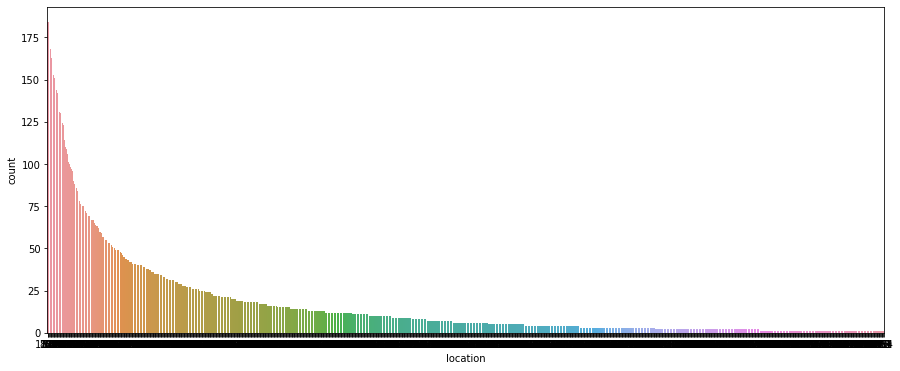

In [27]:
plt.figure(figsize=(15,6))
col = 'location'
sns.countplot(x = col , data = data , order=data[col].value_counts().index)

Text(0, 0.5, 'frequency')

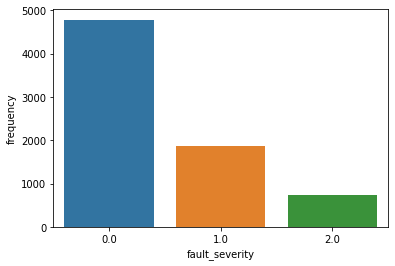

In [28]:
sns.countplot(x = 'fault_severity' , data = data)
plt.ylabel('frequency')

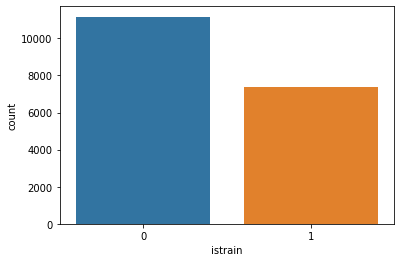

In [29]:
sns.countplot(x = 'istrain' , data = data)

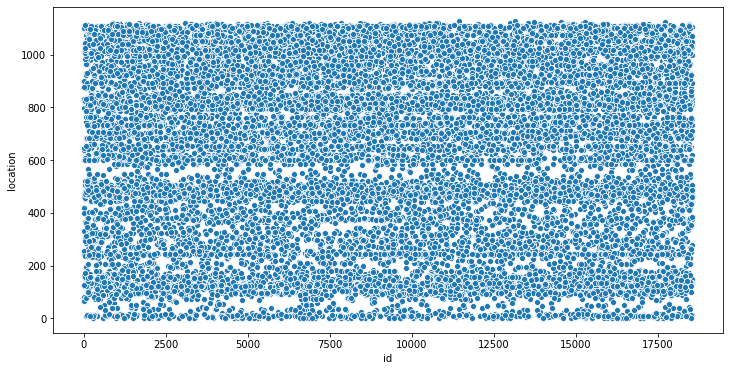

In [30]:
plt.figure(figsize=(12,6))
sns.scatterplot(x = 'id' , y='location' , data= data  , cmap = 'virdis')

# Analysis event type

In [31]:
event_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31170 entries, 0 to 31169
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          31170 non-null  int64 
 1   event_type  31170 non-null  object
dtypes: int64(1), object(1)
memory usage: 487.2+ KB


In [32]:
event_type.head()

,id,event_type
0,6597,event_type 11
1,8011,event_type 15
2,2597,event_type 15
3,5022,event_type 15
4,5022,event_type 11


In [33]:
len(event_type.index)

31170

In [34]:
len(event_type.id.unique())

18552

In [35]:
len(event_type.event_type.unique())

53

In [36]:
event_type.isnull().sum()

id            0
event_type    0
dtype: int64

# cleaning event type

In [37]:
event_type.event_type = event_type.event_type.str.lstrip('event_type').astype('int')
event_type.head()

,id,event_type
0,6597,11
1,8011,15
2,2597,15
3,5022,15
4,5022,11


In [38]:
# one hot encoding using pandas

event_type = pd.get_dummies(event_type)
event_type.head()

,id,event_type
0,6597,11
1,8011,15
2,2597,15
3,5022,15
4,5022,11


# analysis Log features

In [39]:
log_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58671 entries, 0 to 58670
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           58671 non-null  int64 
 1   log_feature  58671 non-null  object
 2   volume       58671 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.3+ MB


In [40]:
log_feature.head()

,id,log_feature,volume
0,6597,feature 68,6
1,8011,feature 68,7
2,2597,feature 68,1
3,5022,feature 172,2
4,5022,feature 56,1


In [41]:
print('total number of rows : ' , len(log_feature.index))
print('number of unique ids :' , len(log_feature.id.unique()))
print('number of unique log features:' , len(log_feature.log_feature.unique()))
print('number of unique volumes :' , len(log_feature.volume.unique()))


total number of rows :  58671
number of unique ids : 18552
number of unique log features: 386
number of unique volumes : 341


In [42]:
log_feature.isnull().sum()

id             0
log_feature    0
volume         0
dtype: int64

# cleaning log features

In [43]:
log_feature['log_feature'] = log_feature['log_feature'].str.lstrip('feature').astype('int')
log_feature.head()

,id,log_feature,volume
0,6597,68,6
1,8011,68,7
2,2597,68,1
3,5022,172,2
4,5022,56,1


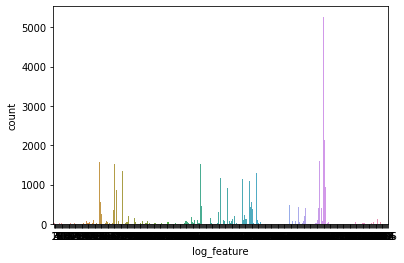

In [44]:
sns.countplot(x = 'log_feature' , data = log_feature)

# Analysis resourse type

In [45]:
resource_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21076 entries, 0 to 21075
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             21076 non-null  int64 
 1   resource_type  21076 non-null  object
dtypes: int64(1), object(1)
memory usage: 329.4+ KB


In [46]:
resource_type.head()

,id,resource_type
0,6597,resource_type 8
1,8011,resource_type 8
2,2597,resource_type 8
3,5022,resource_type 8
4,6852,resource_type 8


In [47]:
# clean the data of resourse type

resource_type['resource_type'] = resource_type['resource_type'].str.lstrip('resource_type').astype('int')
resource_type.head()

,id,resource_type
0,6597,8
1,8011,8
2,2597,8
3,5022,8
4,6852,8


In [48]:
resource_type['resource_type'].value_counts()

8     10268
2      8918
6       582
7       498
4       330
9       190
3       145
10       73
1        58
5        14
Name: resource_type, dtype: int64

In [49]:
resource_type = pd.get_dummies(resource_type , columns=['resource_type'])
resource_type.head()

,id,resource_type_1,resource_type_2,resource_type_3,resource_type_4,resource_type_5,resource_type_6,resource_type_7,resource_type_8,resource_type_9,resource_type_10
0,6597,0,0,0,0,0,0,0,1,0,0
1,8011,0,0,0,0,0,0,0,1,0,0
2,2597,0,0,0,0,0,0,0,1,0,0
3,5022,0,0,0,0,0,0,0,1,0,0
4,6852,0,0,0,0,0,0,0,1,0,0


# Analysis severity type

In [50]:
severity_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18552 entries, 0 to 18551
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             18552 non-null  int64 
 1   severity_type  18552 non-null  object
dtypes: int64(1), object(1)
memory usage: 290.0+ KB


In [51]:
severity_type.head()

,id,severity_type
0,6597,severity_type 2
1,8011,severity_type 2
2,2597,severity_type 2
3,5022,severity_type 1
4,6852,severity_type 1


In [52]:
# cleaning the severity data

severity_type['severity_type'] = severity_type['severity_type'].str.lstrip('severity_type').astype('int')
severity_type.head()

,id,severity_type
0,6597,2
1,8011,2
2,2597,2
3,5022,1
4,6852,1


In [53]:
severity_type['severity_type'].value_counts()

2    8737
1    8728
4    1014
5      65
3       8
Name: severity_type, dtype: int64

In [54]:
# one hot encoding
severity_type = pd.get_dummies(severity_type , columns=['severity_type'])
severity_type.head()

,id,severity_type_1,severity_type_2,severity_type_3,severity_type_4,severity_type_5
0,6597,0,1,0,0,0
1,8011,0,1,0,0,0
2,2597,0,1,0,0,0
3,5022,1,0,0,0,0
4,6852,1,0,0,0,0


# analysis submission data

In [55]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11171 entries, 0 to 11170
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   id         11171 non-null  int64
 1   predict_0  11171 non-null  int64
 2   predict_1  11171 non-null  int64
 3   predict_2  11171 non-null  int64
dtypes: int64(4)
memory usage: 349.2 KB


In [56]:
sample_submission.head()

,id,predict_0,predict_1,predict_2
0,11066,0,1,0
1,18000,0,1,0
2,16964,0,1,0
3,4795,0,1,0
4,3392,0,1,0


# **Feature Engineering**

In [57]:
event_type = event_type.groupby('id', sort=False).agg(sum).add_prefix('sum_').reset_index()

event_type.head()

,id,sum_event_type
0,6597,11
1,8011,15
2,2597,15
3,5022,26
4,6852,26


In [58]:
log_feature = log_feature.groupby('id', sort=False).agg(count_log_feature=('log_feature','count'), 
                                                        sum_volume=('volume', 'sum'),
                                                        mean_volume=('volume', 'mean')
                                                      ).reset_index()
log_feature.head()

,id,count_log_feature,sum_volume,mean_volume
0,6597,1,6,6.000000
1,8011,1,7,7.000000
2,2597,1,1,1.000000
3,5022,4,10,2.500000
4,6852,3,5,1.666667


In [59]:
resource_type = resource_type.groupby('id', sort=False).agg(sum).add_prefix('sum_').reset_index()

resource_type.head()

,id,sum_resource_type_1,sum_resource_type_2,sum_resource_type_3,sum_resource_type_4,sum_resource_type_5,sum_resource_type_6,sum_resource_type_7,sum_resource_type_8,sum_resource_type_9,sum_resource_type_10
0,6597,0,0,0,0,0,0,0,1,0,0
1,8011,0,0,0,0,0,0,0,1,0,0
2,2597,0,0,0,0,0,0,0,1,0,0
3,5022,0,0,0,0,0,0,0,1,0,0
4,6852,0,0,0,0,0,0,0,1,0,0


In [60]:
dfs = [data, log_feature, severity_type, resource_type, event_type] 
df1 = pd.merge(data , log_feature)
df2 = pd.merge(df1 , severity_type)
df3 = pd.merge(df2 , resource_type)
result = pd.merge(df3 , event_type)

result.shape

(18552, 23)

In [61]:
data.shape , log_feature.shape , severity_type.shape , resource_type.shape , event_type.shape

((18552, 4), (18552, 4), (18552, 6), (18552, 11), (18552, 2))

In [62]:
result.head()

,id,location,fault_severity,istrain,count_log_feature,sum_volume,mean_volume,severity_type_1,severity_type_2,severity_type_3,...,sum_resource_type_2,sum_resource_type_3,sum_resource_type_4,sum_resource_type_5,sum_resource_type_6,sum_resource_type_7,sum_resource_type_8,sum_resource_type_9,sum_resource_type_10,sum_event_type
0,14121,118,1.0,1,2,38,19.000000,0,1,0,...,1,0,0,0,0,0,0,0,0,69
1,9320,91,0.0,1,2,316,158.000000,0,1,0,...,1,0,0,0,0,0,0,0,0,69
2,14394,152,1.0,1,2,2,1.000000,0,1,0,...,1,0,0,0,0,0,0,0,0,69
3,8218,931,1.0,1,3,22,7.333333,1,0,0,...,0,0,0,0,0,0,1,0,0,26
4,14804,120,0.0,1,9,12,1.333333,1,0,0,...,1,0,0,0,0,0,1,0,0,101


In [63]:
result.isnull().sum()

id                          0
location                    0
fault_severity          11171
istrain                     0
count_log_feature           0
sum_volume                  0
mean_volume                 0
severity_type_1             0
severity_type_2             0
severity_type_3             0
severity_type_4             0
severity_type_5             0
sum_resource_type_1         0
sum_resource_type_2         0
sum_resource_type_3         0
sum_resource_type_4         0
sum_resource_type_5         0
sum_resource_type_6         0
sum_resource_type_7         0
sum_resource_type_8         0
sum_resource_type_9         0
sum_resource_type_10        0
sum_event_type              0
dtype: int64

# Now its time to split the train and test data set

In [64]:
train = result[result['istrain'] == 1]
train.head()

,id,location,fault_severity,istrain,count_log_feature,sum_volume,mean_volume,severity_type_1,severity_type_2,severity_type_3,...,sum_resource_type_2,sum_resource_type_3,sum_resource_type_4,sum_resource_type_5,sum_resource_type_6,sum_resource_type_7,sum_resource_type_8,sum_resource_type_9,sum_resource_type_10,sum_event_type
0,14121,118,1.0,1,2,38,19.000000,0,1,0,...,1,0,0,0,0,0,0,0,0,69
1,9320,91,0.0,1,2,316,158.000000,0,1,0,...,1,0,0,0,0,0,0,0,0,69
2,14394,152,1.0,1,2,2,1.000000,0,1,0,...,1,0,0,0,0,0,0,0,0,69
3,8218,931,1.0,1,3,22,7.333333,1,0,0,...,0,0,0,0,0,0,1,0,0,26
4,14804,120,0.0,1,9,12,1.333333,1,0,0,...,1,0,0,0,0,0,1,0,0,101


In [65]:
test = result[result['istrain'] == 0]
test.head()

,id,location,fault_severity,istrain,count_log_feature,sum_volume,mean_volume,severity_type_1,severity_type_2,severity_type_3,...,sum_resource_type_2,sum_resource_type_3,sum_resource_type_4,sum_resource_type_5,sum_resource_type_6,sum_resource_type_7,sum_resource_type_8,sum_resource_type_9,sum_resource_type_10,sum_event_type
7381,11066,481,NaN,0,4,98,24.5,0,1,0,...,1,0,0,0,0,0,0,0,0,69
7382,18000,962,NaN,0,2,29,14.5,1,0,0,...,0,0,0,0,0,0,1,0,0,26
7383,16964,491,NaN,0,2,21,10.5,0,1,0,...,1,0,0,0,0,0,0,0,0,69
7384,4795,532,NaN,0,3,3,1.0,0,0,0,...,0,1,0,0,0,0,0,1,0,37
7385,3392,600,NaN,0,2,8,4.0,0,1,0,...,0,0,0,0,0,0,1,0,0,15


# Split the data into training and test sets

In [66]:
from sklearn.model_selection import train_test_split

np.random.seed(0)

X = train.drop(columns='fault_severity')

# Prediction target - Training data
y = train['fault_severity']

# Selected features - Test data
x = test.drop(columns='fault_severity')

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

print("Train Validation Split Complete")

Train Validation Split Complete


# Scalling

In [67]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)

In [68]:
X_train.shape , X_valid.shape

((5904, 22), (1477, 22))

In [69]:
print(tf.__version__)

2.1.0


# Data Modelling

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RNN 
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense , Activation , Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()

model.add(Dense(16 , activation = 'relu'))

model.add(Dense(16 , activation = 'relu'))

model.add(Dense(16 , activation = 'relu'))

model.add(Dense(16 , activation = 'relu'))


model.add(Dense(1))


early_stop = EarlyStopping(monitor = 'val_loss' , mode = 'min' , verbose = 1 , patience = 25)




In [71]:
model.compile(optimizer = 'adam' , loss = 'mse' , metrics = ['accuracy'])

# training the model

In [72]:
model.fit(x = X_train , y = y_train.values , validation_data = (X_valid , y_valid.values) , batch_size = 128 , epochs = 200 , callbacks = [early_stop])

Train on 5904 samples, validate on 1477 samples
Epoch 1/200
5904/5904 [==============================] - 3s 526us/sample - loss: 0.4634 - accuracy: 0.6286 - val_loss: 0.4154 - val_accuracy: 0.5843
Epoch 2/200
5904/5904 [==============================] - 0s 27us/sample - loss: 0.3907 - accuracy: 0.5755 - val_loss: 0.3953 - val_accuracy: 0.5552
Epoch 3/200
5904/5904 [==============================] - 0s 27us/sample - loss: 0.3811 - accuracy: 0.5476 - val_loss: 0.3888 - val_accuracy: 0.5430
Epoch 4/200
5904/5904 [==============================] - 0s 27us/sample - loss: 0.3769 - accuracy: 0.5476 - val_loss: 0.3845 - val_accuracy: 0.5457
Epoch 5/200
5904/5904 [==============================] - 0s 28us/sample - loss: 0.3718 - accuracy: 0.5525 - val_loss: 0.3807 - val_accuracy: 0.5498
Epoch 6/200
5904/5904 [==============================] - 0s 27us/sample - loss: 0.3671 - accuracy: 0.5556 - val_loss: 0.3826 - val_accuracy: 0.5721
Epoch 7/200
5904/5904 [==============================] - 0s 28u

Epoch 56/200
5904/5904 [==============================] - 0s 26us/sample - loss: 0.3033 - accuracy: 0.6348 - val_loss: 0.3290 - val_accuracy: 0.6290
Epoch 57/200
5904/5904 [==============================] - 0s 24us/sample - loss: 0.3036 - accuracy: 0.6389 - val_loss: 0.3237 - val_accuracy: 0.6276
Epoch 58/200
5904/5904 [==============================] - 0s 27us/sample - loss: 0.3000 - accuracy: 0.6467 - val_loss: 0.3229 - val_accuracy: 0.6303
Epoch 59/200
5904/5904 [==============================] - 0s 23us/sample - loss: 0.3026 - accuracy: 0.6384 - val_loss: 0.3243 - val_accuracy: 0.6127
Epoch 60/200
5904/5904 [==============================] - 0s 26us/sample - loss: 0.3035 - accuracy: 0.6380 - val_loss: 0.3216 - val_accuracy: 0.6134
Epoch 61/200
5904/5904 [==============================] - 0s 24us/sample - loss: 0.3005 - accuracy: 0.6406 - val_loss: 0.3208 - val_accuracy: 0.6121
Epoch 62/200
5904/5904 [==============================] - 0s 25us/sample - loss: 0.3009 - accuracy: 0.6409

Epoch 111/200
5904/5904 [==============================] - 0s 26us/sample - loss: 0.2875 - accuracy: 0.6507 - val_loss: 0.3104 - val_accuracy: 0.6175
Epoch 112/200
5904/5904 [==============================] - 0s 24us/sample - loss: 0.2862 - accuracy: 0.6524 - val_loss: 0.3093 - val_accuracy: 0.6087
Epoch 113/200
5904/5904 [==============================] - 0s 23us/sample - loss: 0.2862 - accuracy: 0.6567 - val_loss: 0.3177 - val_accuracy: 0.6229
Epoch 114/200
5904/5904 [==============================] - 0s 26us/sample - loss: 0.2866 - accuracy: 0.6550 - val_loss: 0.3148 - val_accuracy: 0.6114
Epoch 115/200
5904/5904 [==============================] - 0s 27us/sample - loss: 0.2900 - accuracy: 0.6550 - val_loss: 0.3086 - val_accuracy: 0.6188
Epoch 116/200
5904/5904 [==============================] - 0s 27us/sample - loss: 0.2865 - accuracy: 0.6468 - val_loss: 0.3085 - val_accuracy: 0.6175
Epoch 117/200
5904/5904 [==============================] - 0s 24us/sample - loss: 0.2845 - accuracy:

In [73]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  368       
_________________________________________________________________
dense_1 (Dense)              multiple                  272       
_________________________________________________________________
dense_2 (Dense)              multiple                  272       
_________________________________________________________________
dense_3 (Dense)              multiple                  272       
_________________________________________________________________
dense_4 (Dense)              multiple                  17        
Total params: 1,201
Trainable params: 1,201
Non-trainable params: 0
_________________________________________________________________


In [74]:
model.history.history

{'loss': [0.46344824930839745,
  0.39068955594931193,
  0.38112939954773195,
  0.3769045497989913,
  0.37178026991807994,
  0.36706039075282854,
  0.36470877389274636,
  0.361032322493349,
  0.3574236914071287,
  0.35365869888283696,
  0.34990700118263884,
  0.34525120274484317,
  0.34283665331398566,
  0.3439981119257971,
  0.33937223962328944,
  0.33397203199262543,
  0.3332323987632586,
  0.33261529749971097,
  0.32762969687056087,
  0.3265354694712776,
  0.32839701427676815,
  0.3251827171824489,
  0.32278415068055233,
  0.32312830458811626,
  0.3207571189901047,
  0.3192935546804573,
  0.3196773273835014,
  0.3193473401592999,
  0.31777503343455515,
  0.3175714852687143,
  0.3169586904003691,
  0.31489909272691424,
  0.31431845129343877,
  0.3145350376522638,
  0.3125847920492736,
  0.3134484136007666,
  0.31246682056566566,
  0.31261042010816453,
  0.31473618164295103,
  0.31065563651604383,
  0.31088219716296933,
  0.30954345269254874,
  0.3086431031304646,
  0.30812838374760737

In [75]:
losses = pd.DataFrame(model.history.history)

<Figure size 864x1080 with 0 Axes>

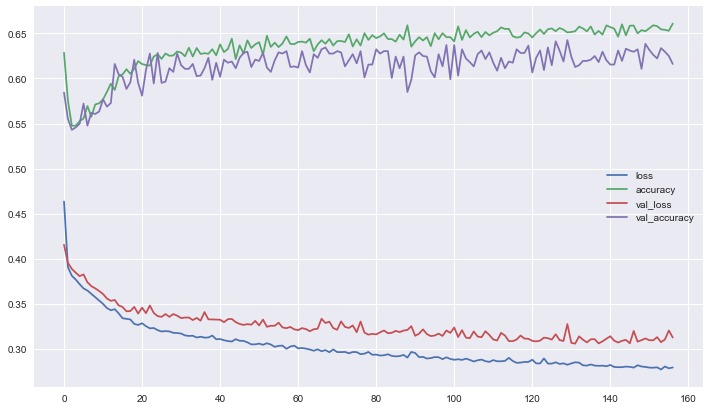

In [76]:
plt.style.use('seaborn')
plt.figure(figsize=(12,15))
losses.plot(kind = 'line' , figsize=(12,7))

# Evaluation on Test data

In [77]:
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score , explained_variance_score , classification_report , confusion_matrix , precision_score , accuracy_score , recall_score , f1_score

In [78]:
y_preds = model.predict(X_valid)

In [79]:
mean_absolute_error(y_valid , y_preds)

0.4185704208794444

In [80]:
mean_squared_error(y_valid  , y_preds)

0.3125692725014967

In [81]:
explained_variance_score(y_valid , y_preds)

0.3180585645370969

In [82]:
np.sqrt(mean_squared_error(y_valid , y_preds))

0.5590789501505996

In [83]:
r2_score(y_valid , y_preds)

0.3153880968115542

In [84]:
scores = pd.DataFrame({'mean absoulte error' : mean_absolute_error(y_valid , y_preds),
                      'mean squared error' : mean_squared_error(y_valid  , y_preds),
                      'explained variance score' : explained_variance_score(y_valid , y_preds),
                      'sqrt of mean squared error' : np.sqrt(mean_squared_error(y_valid , y_preds)),
                      'r2 score' : r2_score(y_valid , y_preds)} , index = ['scores'])

In [85]:
scores.transpose()

,scores
mean absoulte error,0.418570
mean squared error,0.312569
explained variance score,0.318059
sqrt of mean squared error,0.559079
r2 score,0.315388


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

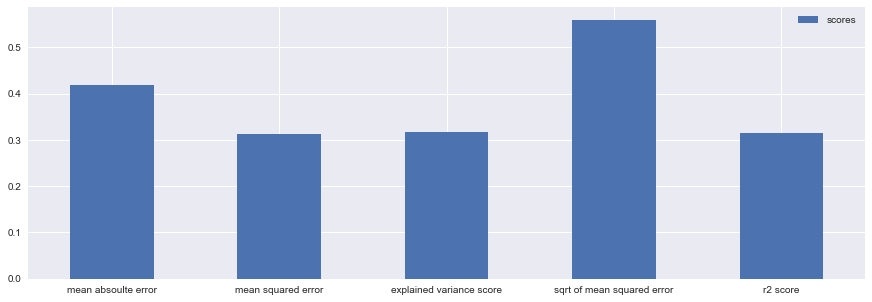

In [86]:
scores.transpose().plot(kind = 'bar' , figsize=(15,5))
plt.xticks(rotation = 0)

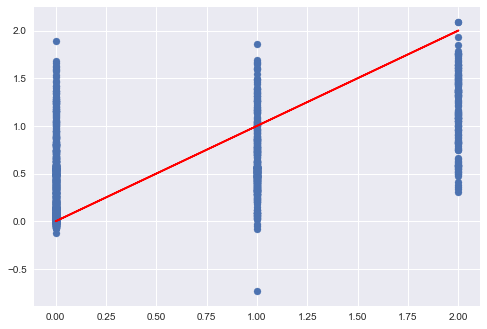

In [87]:
# our prediction

plt.scatter(y_valid , y_preds);

plt.plot(y_valid , y_valid , 'r')

In [88]:
y_valid.shape

(1477,)

In [89]:
errors = y_valid.values.reshape(1477 , 1) - y_preds

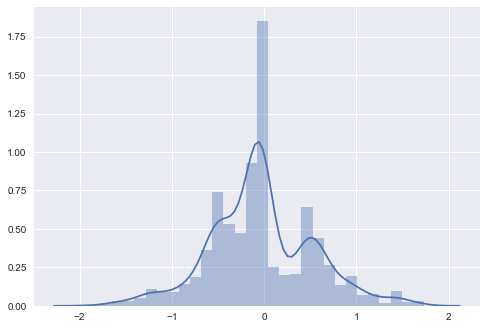

In [91]:
sns.distplot(errors , bins = 30)

# Training the model by tuning the hyperparameters of the optimizers

* In this case we are using momentum ( to imrove the learning rate ) 
* Dropouts to decrease the number of nodes in every layers
* Learning rate

In [138]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RNN 
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense , Activation , Dropout
from tensorflow.keras.optimizers import Adam , RMSprop
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()

model.add(Dense(16 , activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(16 , activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(16 , activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(16 , activation = 'relu'))
model.add(Dropout(0.5))


model.add(Dense(1))


early_stop = EarlyStopping(monitor = 'val_loss' , mode = 'min' , verbose = 1 , patience = 25)

opt = tf.keras.optimizers.Adam(learning_rate= 0.0001 )


In [129]:
model.compile(optimizer = opt , loss = 'mse' , metrics = ['accuracy'])

In [130]:
model.fit(x = X_train , y = y_train.values , validation_data = (X_valid , y_valid.values) , batch_size = 128 , epochs = 200 , callbacks = [early_stop])

Train on 5904 samples, validate on 1477 samples
Epoch 1/200
5904/5904 [==============================] - 1s 247us/sample - loss: 1.1718 - accuracy: 0.6418 - val_loss: 0.7489 - val_accuracy: 0.6486
Epoch 2/200
5904/5904 [==============================] - 0s 36us/sample - loss: 1.0163 - accuracy: 0.6391 - val_loss: 0.7019 - val_accuracy: 0.6486
Epoch 3/200
5904/5904 [==============================] - 0s 35us/sample - loss: 0.9111 - accuracy: 0.6404 - val_loss: 0.6677 - val_accuracy: 0.6486
Epoch 4/200
5904/5904 [==============================] - 0s 36us/sample - loss: 0.8296 - accuracy: 0.6413 - val_loss: 0.6438 - val_accuracy: 0.6486
Epoch 5/200
5904/5904 [==============================] - 0s 35us/sample - loss: 0.7698 - accuracy: 0.6413 - val_loss: 0.6234 - val_accuracy: 0.6486
Epoch 6/200
5904/5904 [==============================] - 0s 35us/sample - loss: 0.7298 - accuracy: 0.6404 - val_loss: 0.6065 - val_accuracy: 0.6486
Epoch 7/200
5904/5904 [==============================] - 0s 35u

Epoch 56/200
5904/5904 [==============================] - 0s 34us/sample - loss: 0.4498 - accuracy: 0.5508 - val_loss: 0.4494 - val_accuracy: 0.6486
Epoch 57/200
5904/5904 [==============================] - 0s 32us/sample - loss: 0.4482 - accuracy: 0.5664 - val_loss: 0.4489 - val_accuracy: 0.6486
Epoch 58/200
5904/5904 [==============================] - 0s 31us/sample - loss: 0.4500 - accuracy: 0.5537 - val_loss: 0.4486 - val_accuracy: 0.6486
Epoch 59/200
5904/5904 [==============================] - 0s 31us/sample - loss: 0.4464 - accuracy: 0.5601 - val_loss: 0.4479 - val_accuracy: 0.6486
Epoch 60/200
5904/5904 [==============================] - 0s 34us/sample - loss: 0.4496 - accuracy: 0.5595 - val_loss: 0.4472 - val_accuracy: 0.6486
Epoch 61/200
5904/5904 [==============================] - 0s 32us/sample - loss: 0.4493 - accuracy: 0.5501 - val_loss: 0.4465 - val_accuracy: 0.6486
Epoch 62/200
5904/5904 [==============================] - 0s 33us/sample - loss: 0.4466 - accuracy: 0.5633

Epoch 111/200
5904/5904 [==============================] - 0s 31us/sample - loss: 0.4250 - accuracy: 0.5505 - val_loss: 0.4164 - val_accuracy: 0.5471
Epoch 112/200
5904/5904 [==============================] - 0s 33us/sample - loss: 0.4252 - accuracy: 0.5539 - val_loss: 0.4162 - val_accuracy: 0.5484
Epoch 113/200
5904/5904 [==============================] - 0s 36us/sample - loss: 0.4264 - accuracy: 0.5527 - val_loss: 0.4159 - val_accuracy: 0.5477
Epoch 114/200
5904/5904 [==============================] - 0s 35us/sample - loss: 0.4250 - accuracy: 0.5530 - val_loss: 0.4156 - val_accuracy: 0.5477
Epoch 115/200
5904/5904 [==============================] - 0s 36us/sample - loss: 0.4287 - accuracy: 0.5483 - val_loss: 0.4157 - val_accuracy: 0.5477
Epoch 116/200
5904/5904 [==============================] - 0s 35us/sample - loss: 0.4268 - accuracy: 0.5479 - val_loss: 0.4153 - val_accuracy: 0.5477
Epoch 117/200
5904/5904 [==============================] - 0s 32us/sample - loss: 0.4277 - accuracy:

5904/5904 [==============================] - 0s 34us/sample - loss: 0.4107 - accuracy: 0.5579 - val_loss: 0.4091 - val_accuracy: 0.5450
Epoch 166/200
5904/5904 [==============================] - 0s 30us/sample - loss: 0.4124 - accuracy: 0.5503 - val_loss: 0.4091 - val_accuracy: 0.5457
Epoch 167/200
5904/5904 [==============================] - 0s 32us/sample - loss: 0.4114 - accuracy: 0.5559 - val_loss: 0.4089 - val_accuracy: 0.5450
Epoch 168/200
5904/5904 [==============================] - 0s 32us/sample - loss: 0.4126 - accuracy: 0.5444 - val_loss: 0.4088 - val_accuracy: 0.5457
Epoch 169/200
5904/5904 [==============================] - 0s 32us/sample - loss: 0.4103 - accuracy: 0.5552 - val_loss: 0.4086 - val_accuracy: 0.5464
Epoch 170/200
5904/5904 [==============================] - 0s 35us/sample - loss: 0.4100 - accuracy: 0.5495 - val_loss: 0.4085 - val_accuracy: 0.5471
Epoch 171/200
5904/5904 [==============================] - 0s 33us/sample - loss: 0.4136 - accuracy: 0.5491 - val_

In [131]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             multiple                  368       
_________________________________________________________________
dropout_20 (Dropout)         multiple                  0         
_________________________________________________________________
dense_31 (Dense)             multiple                  272       
_________________________________________________________________
dropout_21 (Dropout)         multiple                  0         
_________________________________________________________________
dense_32 (Dense)             multiple                  272       
_________________________________________________________________
dropout_22 (Dropout)         multiple                  0         
_________________________________________________________________
dense_33 (Dense)             multiple                 

In [132]:
model.history.history

{'loss': [1.171817055239587,
  1.0162925923742898,
  0.9110972068012568,
  0.8295779984171797,
  0.7698251590496157,
  0.7297908035397207,
  0.7029679084857952,
  0.6605147467396124,
  0.6295661620977449,
  0.6197947580316848,
  0.5913495326106787,
  0.5772719972824986,
  0.5633148245695161,
  0.554909114915181,
  0.5402286068856877,
  0.5334129393262269,
  0.5302793993374842,
  0.5195224758409226,
  0.5096995439632799,
  0.5020919552017357,
  0.5008574290488793,
  0.4925031364771732,
  0.4934667760763711,
  0.48669567922266516,
  0.48536092729426333,
  0.47886689524178905,
  0.47898890752456375,
  0.476447834070459,
  0.47580865243586096,
  0.47341854559373725,
  0.46935563116538814,
  0.47578594064324853,
  0.46460534612014687,
  0.46390807386336286,
  0.46700783134475954,
  0.4672365153061988,
  0.46551195602752976,
  0.4627209776623785,
  0.45922118457675304,
  0.4623383441914711,
  0.4599894078443367,
  0.4576481315824721,
  0.45486115989323234,
  0.4543660633609224,
  0.458677319

In [133]:
losses1 = pd.DataFrame(model.history.history)

Text(0.5, 1.0, 'Graph when learning rate is 0.005')

<Figure size 864x1080 with 0 Axes>

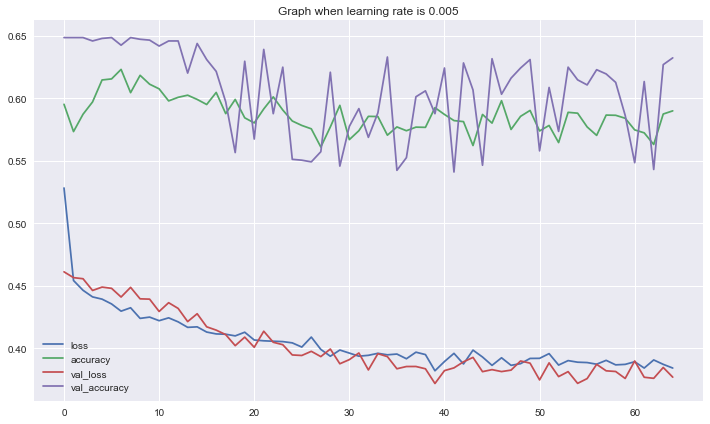

In [113]:
plt.style.use('seaborn')
plt.figure(figsize=(12,15))
losses1.plot(kind = 'line' , figsize=(12,7))
plt.title('Graph when learning rate is 0.005')

Text(0.5, 1.0, 'Graph when learning rate is 0.001')

<Figure size 864x1080 with 0 Axes>

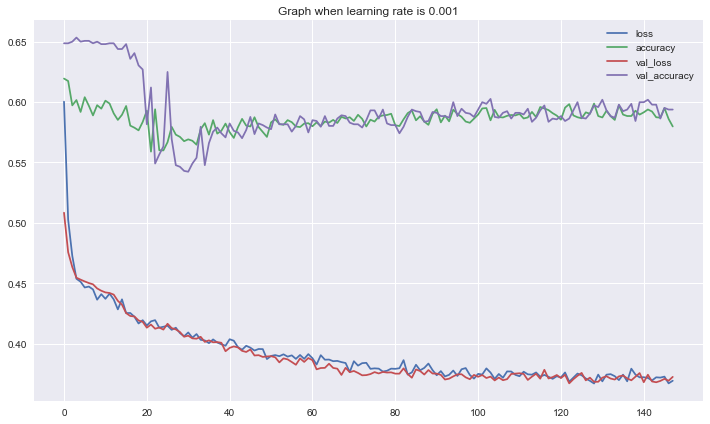

In [120]:
plt.style.use('seaborn')
plt.figure(figsize=(12,15))
losses1.plot(kind = 'line' , figsize=(12,7))
plt.title('Graph when learning rate is 0.001')

Text(0.5, 1.0, 'Graph when learning rate is 0.1')

<Figure size 864x1080 with 0 Axes>

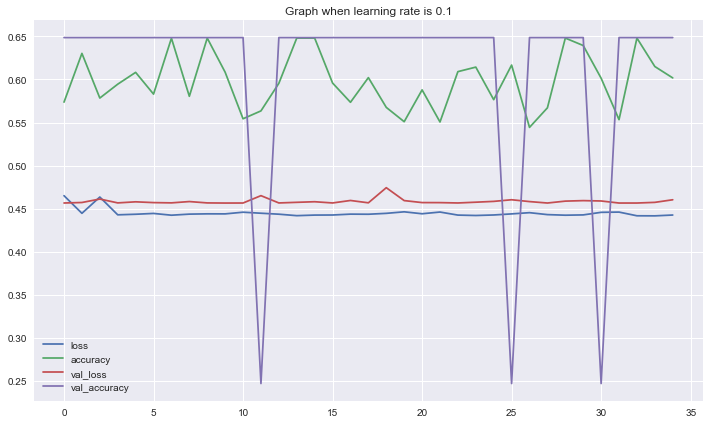

In [127]:
plt.style.use('seaborn')
plt.figure(figsize=(12,15))
losses1.plot(kind = 'line' , figsize=(12,7))
plt.title('Graph when learning rate is 0.1')

Text(0.5, 1.0, 'Graph when learning rate is 0.0001')

<Figure size 864x1080 with 0 Axes>

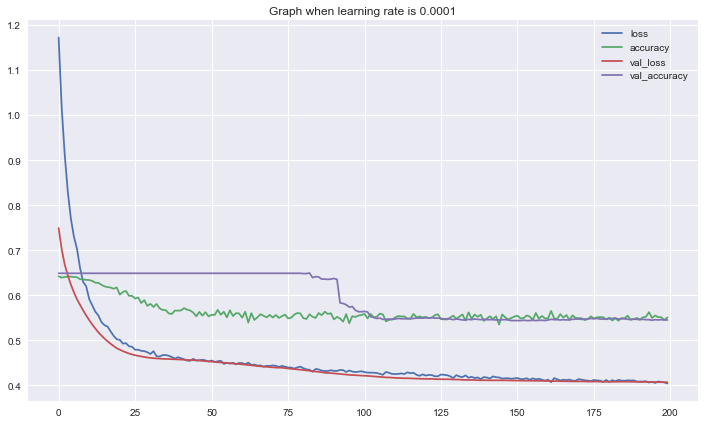

In [134]:
plt.style.use('seaborn')
plt.figure(figsize=(12,15))
losses1.plot(kind = 'line' , figsize=(12,7))
plt.title('Graph when learning rate is 0.0001')

# Try to train the model with SGD optimizer so that we can tune the model based on MOMENTUM

In [161]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RNN 
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense , Activation , Dropout
from tensorflow.keras.optimizers import Adam , RMSprop ,SGD
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()

model.add(Dense(16 , activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(16 , activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(16 , activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(16 , activation = 'relu'))
model.add(Dropout(0.5))


model.add(Dense(1))


early_stop = EarlyStopping(monitor = 'val_loss' , mode = 'min' , verbose = 1 , patience = 25)

opt = tf.keras.optimizers.SGD(learning_rate= 0.00001 , momentum=0.99)


In [162]:
model.compile(optimizer = opt , loss = 'mse' , metrics = ['accuracy'])

In [163]:
model.fit(x = X_train , y = y_train.values , validation_data = (X_valid , y_valid.values) , batch_size = 128 , epochs = 200 , callbacks = [early_stop])

Train on 5904 samples, validate on 1477 samples
Epoch 1/200
5904/5904 [==============================] - 1s 219us/sample - loss: 0.6879 - accuracy: 0.5783 - val_loss: 0.5694 - val_accuracy: 0.6486
Epoch 2/200
5904/5904 [==============================] - 0s 37us/sample - loss: 0.6812 - accuracy: 0.5777 - val_loss: 0.5604 - val_accuracy: 0.6486
Epoch 3/200
5904/5904 [==============================] - 0s 34us/sample - loss: 0.6622 - accuracy: 0.5901 - val_loss: 0.5492 - val_accuracy: 0.6486
Epoch 4/200
5904/5904 [==============================] - 0s 34us/sample - loss: 0.6424 - accuracy: 0.5793 - val_loss: 0.5382 - val_accuracy: 0.6486
Epoch 5/200
5904/5904 [==============================] - 0s 36us/sample - loss: 0.6090 - accuracy: 0.5811 - val_loss: 0.5282 - val_accuracy: 0.6486
Epoch 6/200
5904/5904 [==============================] - 0s 35us/sample - loss: 0.5921 - accuracy: 0.5708 - val_loss: 0.5200 - val_accuracy: 0.6486
Epoch 7/200
5904/5904 [==============================] - 0s 35u

Epoch 56/200
5904/5904 [==============================] - 0s 33us/sample - loss: 0.4537 - accuracy: 0.5669 - val_loss: 0.4609 - val_accuracy: 0.6486
Epoch 57/200
5904/5904 [==============================] - 0s 31us/sample - loss: 0.4514 - accuracy: 0.5657 - val_loss: 0.4607 - val_accuracy: 0.6486
Epoch 58/200
5904/5904 [==============================] - 0s 32us/sample - loss: 0.4533 - accuracy: 0.5681 - val_loss: 0.4606 - val_accuracy: 0.6486
Epoch 59/200
5904/5904 [==============================] - 0s 30us/sample - loss: 0.4498 - accuracy: 0.5733 - val_loss: 0.4605 - val_accuracy: 0.6486
Epoch 60/200
5904/5904 [==============================] - 0s 30us/sample - loss: 0.4542 - accuracy: 0.5720 - val_loss: 0.4604 - val_accuracy: 0.6486
Epoch 61/200
5904/5904 [==============================] - 0s 33us/sample - loss: 0.4527 - accuracy: 0.5723 - val_loss: 0.4603 - val_accuracy: 0.6486
Epoch 62/200
5904/5904 [==============================] - 0s 33us/sample - loss: 0.4512 - accuracy: 0.5832

5904/5904 [==============================] - 0s 34us/sample - loss: 0.4460 - accuracy: 0.5816 - val_loss: 0.4572 - val_accuracy: 0.6486
Epoch 111/200
5904/5904 [==============================] - 0s 29us/sample - loss: 0.4453 - accuracy: 0.5932 - val_loss: 0.4572 - val_accuracy: 0.6486
Epoch 112/200
5904/5904 [==============================] - 0s 29us/sample - loss: 0.4463 - accuracy: 0.5903 - val_loss: 0.4571 - val_accuracy: 0.6486
Epoch 113/200
5904/5904 [==============================] - 0s 30us/sample - loss: 0.4430 - accuracy: 0.5955 - val_loss: 0.4571 - val_accuracy: 0.6486
Epoch 114/200
5904/5904 [==============================] - 0s 30us/sample - loss: 0.4429 - accuracy: 0.5976 - val_loss: 0.4571 - val_accuracy: 0.6486
Epoch 115/200
5904/5904 [==============================] - 0s 32us/sample - loss: 0.4455 - accuracy: 0.5862 - val_loss: 0.4570 - val_accuracy: 0.6486
Epoch 116/200
5904/5904 [==============================] - 0s 31us/sample - loss: 0.4452 - accuracy: 0.5899 - val_

5904/5904 [==============================] - 0s 32us/sample - loss: 0.4404 - accuracy: 0.6026 - val_loss: 0.4560 - val_accuracy: 0.6486
Epoch 165/200
5904/5904 [==============================] - 0s 31us/sample - loss: 0.4415 - accuracy: 0.6082 - val_loss: 0.4560 - val_accuracy: 0.6486
Epoch 166/200
5904/5904 [==============================] - 0s 31us/sample - loss: 0.4411 - accuracy: 0.6126 - val_loss: 0.4559 - val_accuracy: 0.6486
Epoch 167/200
5904/5904 [==============================] - 0s 31us/sample - loss: 0.4401 - accuracy: 0.6123 - val_loss: 0.4559 - val_accuracy: 0.6486
Epoch 168/200
5904/5904 [==============================] - 0s 31us/sample - loss: 0.4419 - accuracy: 0.5998 - val_loss: 0.4559 - val_accuracy: 0.6486
Epoch 169/200
5904/5904 [==============================] - 0s 30us/sample - loss: 0.4430 - accuracy: 0.6040 - val_loss: 0.4559 - val_accuracy: 0.6486
Epoch 170/200
5904/5904 [==============================] - 0s 31us/sample - loss: 0.4429 - accuracy: 0.6057 - val_

In [164]:
losses2 = pd.DataFrame(model.history.history)

Text(0.5, 1.0, 'Graph when learning rate is 0.001 and momentum is 0.9')

<Figure size 864x1080 with 0 Axes>

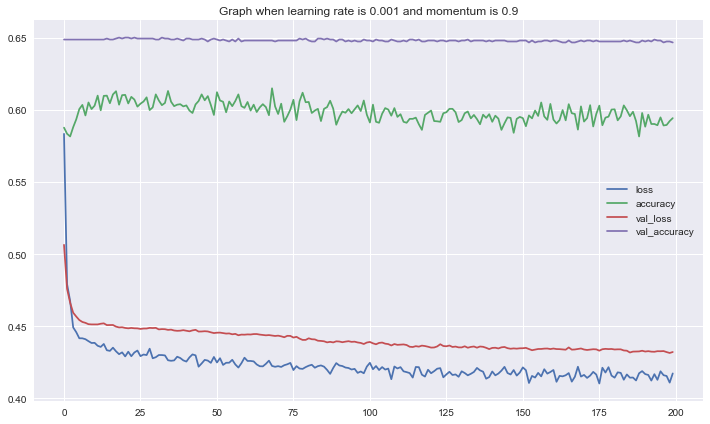

In [155]:
plt.style.use('seaborn')
plt.figure(figsize=(12,15))
losses2.plot(kind = 'line' , figsize=(12,7))
plt.title('Graph when learning rate is 0.001 and momentum is 0.9')

Text(0.5, 1.0, 'Graph when learning rate is 0.0001 and momentum is 0.5')

<Figure size 864x1080 with 0 Axes>

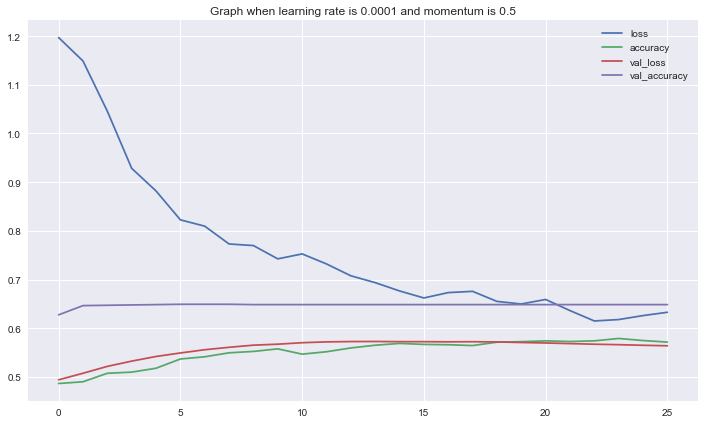

In [160]:
plt.style.use('seaborn')
plt.figure(figsize=(12,15))
losses2.plot(kind = 'line' , figsize=(12,7))
plt.title('Graph when learning rate is 0.0001 and momentum is 0.5')

Text(0.5, 1.0, 'Graph when learning rate is 0.00001 and momentum is 0.99')

<Figure size 864x1080 with 0 Axes>

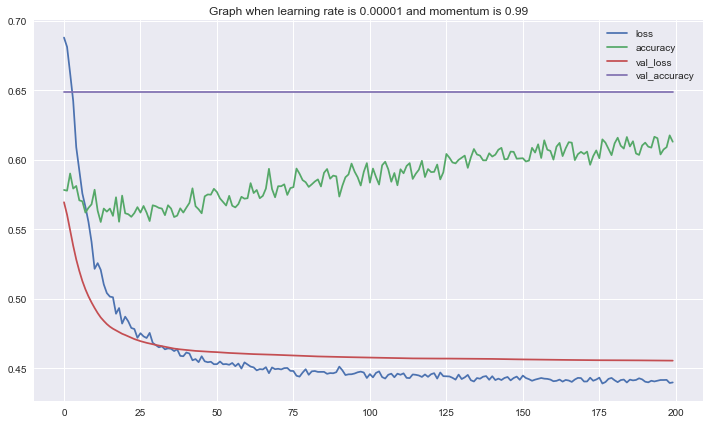

In [165]:
plt.style.use('seaborn')
plt.figure(figsize=(12,15))
losses2.plot(kind = 'line' , figsize=(12,7))
plt.title('Graph when learning rate is 0.00001 and momentum is 0.99')

## From the above graphs we can conclude that by dropping the learning rate and increasing the momentum tends to 1 the accuracry of the model can be increased. And this case applies to all the layered models like Dense  , RNN , LSTM etc

# Training the model using LSTM ( Long Short Term Memory ) Neural network

In [166]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , LSTM ,Embedding
from tensorflow.keras.optimizers import Adam

#model = Sequential()

#model.add(LSTM(22 , input_shape = (22 , 1)))
#model.add(LSTM(22))
#model.add(LSTM(22))
#model.add(LSTM(22))

#model.add(LSTM(1 , input_shape = ()))
#model.add(Activation('softmax'))

In [167]:
model = tf.keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 22 internal units.
model.add(LSTM(22))

# Add a Dense layer with 10 units.
model.add(Dense(10))

model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
lstm (LSTM)                  (None, 22)                7656      
_________________________________________________________________
dense_90 (Dense)             (None, 10)                230       
Total params: 71,886
Trainable params: 71,886
Non-trainable params: 0
_________________________________________________________________


In [168]:
model.compile(optimizer = 'adam' , loss = 'sparse_categorical_crossentropy' , metrics = ['categorical_accuracy'] )

In [169]:
model.fit(x = X_train , y = y_train.values , validation_data = (X_valid , y_valid.values) , batch_size = 128 , epochs = 100)

Train on 5904 samples, validate on 1477 samples
Epoch 1/100
5904/5904 [==============================] - 6s 1ms/sample - loss: 0.9547 - categorical_accuracy: 0.8963 - val_loss: 0.8530 - val_categorical_accuracy: 1.0000
Epoch 2/100
5904/5904 [==============================] - 1s 184us/sample - loss: 0.8427 - categorical_accuracy: 1.0000 - val_loss: 0.8259 - val_categorical_accuracy: 1.0000
Epoch 3/100
5904/5904 [==============================] - 1s 190us/sample - loss: 0.8308 - categorical_accuracy: 0.9998 - val_loss: 0.8104 - val_categorical_accuracy: 0.9993
Epoch 4/100
5904/5904 [==============================] - 1s 186us/sample - loss: 0.8236 - categorical_accuracy: 0.9946 - val_loss: 0.8600 - val_categorical_accuracy: 0.9810
Epoch 5/100
5904/5904 [==============================] - 1s 186us/sample - loss: 0.8506 - categorical_accuracy: 0.9842 - val_loss: 0.8629 - val_categorical_accuracy: 0.9722
Epoch 6/100
5904/5904 [==============================] - 1s 187us/sample - loss: 0.8485 -

Epoch 48/100
5904/5904 [==============================] - 1s 183us/sample - loss: 0.8361 - categorical_accuracy: 1.0000 - val_loss: 0.8367 - val_categorical_accuracy: 1.0000
Epoch 49/100
5904/5904 [==============================] - 1s 183us/sample - loss: 0.8257 - categorical_accuracy: 1.0000 - val_loss: 0.8215 - val_categorical_accuracy: 1.0000
Epoch 50/100
5904/5904 [==============================] - 1s 184us/sample - loss: 0.8072 - categorical_accuracy: 1.0000 - val_loss: 0.7999 - val_categorical_accuracy: 1.0000
Epoch 51/100
5904/5904 [==============================] - 1s 184us/sample - loss: 0.8308 - categorical_accuracy: 1.0000 - val_loss: 0.8790 - val_categorical_accuracy: 1.0000
Epoch 52/100
5904/5904 [==============================] - 1s 183us/sample - loss: 0.8669 - categorical_accuracy: 1.0000 - val_loss: 0.9102 - val_categorical_accuracy: 1.0000
Epoch 53/100
5904/5904 [==============================] - 1s 178us/sample - loss: 0.8787 - categorical_accuracy: 1.0000 - val_loss

5904/5904 [==============================] - 1s 185us/sample - loss: 0.7739 - categorical_accuracy: 1.0000 - val_loss: 0.7833 - val_categorical_accuracy: 1.0000
Epoch 96/100
5904/5904 [==============================] - 1s 195us/sample - loss: 0.7740 - categorical_accuracy: 1.0000 - val_loss: 0.7833 - val_categorical_accuracy: 1.0000
Epoch 97/100
5904/5904 [==============================] - 1s 190us/sample - loss: 0.7736 - categorical_accuracy: 1.0000 - val_loss: 0.7838 - val_categorical_accuracy: 1.0000
Epoch 98/100
5904/5904 [==============================] - 1s 195us/sample - loss: 0.7842 - categorical_accuracy: 1.0000 - val_loss: 0.7837 - val_categorical_accuracy: 1.0000
Epoch 99/100
5904/5904 [==============================] - 1s 194us/sample - loss: 0.7744 - categorical_accuracy: 1.0000 - val_loss: 0.7831 - val_categorical_accuracy: 1.0000
Epoch 100/100
5904/5904 [==============================] - 1s 186us/sample - loss: 0.7731 - categorical_accuracy: 1.0000 - val_loss: 0.7823 - v

In [170]:
model.history.history

{'loss': [0.9547183869007804,
  0.8426841403733747,
  0.8308220969306098,
  0.8236079529372011,
  0.8505841353075291,
  0.8485065811694799,
  0.8517182039697642,
  0.8531482584754303,
  0.846170179889131,
  0.8501974570395824,
  0.8483587715037793,
  0.8368787868882259,
  0.8415712773961427,
  0.8326368113843406,
  0.8488518317863547,
  0.8478432827525668,
  0.8500790925529914,
  0.8485133976632664,
  0.8521851646867871,
  0.8561878844005305,
  0.8470508994125738,
  0.8510961668278144,
  0.8490192515417166,
  0.8476203137296972,
  0.8485128461183894,
  0.8470412234303751,
  0.8468495487843749,
  0.846743852142396,
  0.8729292435374686,
  0.8295652517458287,
  0.8260406817847151,
  0.8277137621954528,
  0.8498057866807229,
  0.8281110707660354,
  0.7960240443547567,
  0.7936222501563509,
  0.7908761068411313,
  0.8101202401365368,
  0.8515241562835569,
  0.8512348492294146,
  0.8506639533572726,
  0.849737612535637,
  0.8492989194425464,
  0.8499762202666058,
  0.8850731045250001,
  0.9

In [171]:
losses_ls = pd.DataFrame(model.history.history)


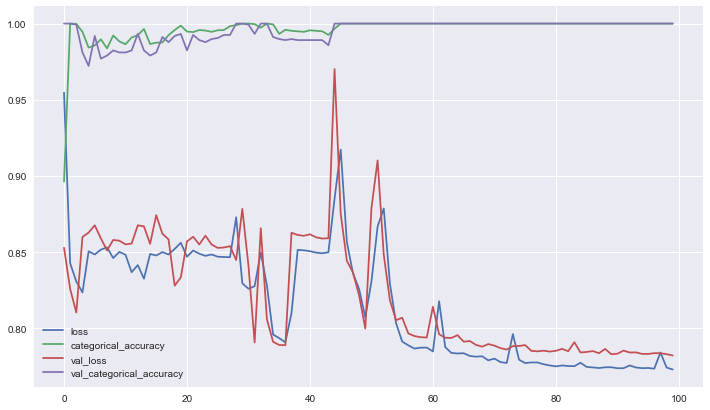

In [172]:
plt.style.use('seaborn')
#plt.figure(figsize=(12,15))
losses_ls.plot(kind = 'line' , figsize=(12,7))

* The curve above shows that at initial epochs there was a fluctuation in val_loss , loss and categorical_accuracy then there is a perfect categorical accuracy with respect to epochs

* After increasing the number of epochs there will be no change in the categorical_accuracy or val_loss or we can say the model gets overfitted thats why we use 50 epochs for training. 

# Now its time to train the LSTM model by tuning the hyperparameters such as dropping out the layers using early stopping different optimizer etc

In [226]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM , Embedding , Dense , Dropout
from tensorflow.keras.optimizers import Adam , SGD , RMSprop
from tensorflow.keras.callbacks import EarlyStopping

model = tf.keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 22 internal units.
model.add(LSTM(22))
model.add(Dropout(0.5))
# Add a Dense layer with 10 units.
model.add(Dense(10))

early_stopng = EarlyStopping(monitor = 'val_loss' , mode = 'min' , verbose = 1 , patience = 25)

opt_adam = Adam(learning_rate = 0.001)


model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 64)          64000     
_________________________________________________________________
lstm_16 (LSTM)               (None, 22)                7656      
_________________________________________________________________
dropout_81 (Dropout)         (None, 22)                0         
_________________________________________________________________
dense_103 (Dense)            (None, 10)                230       
Total params: 71,886
Trainable params: 71,886
Non-trainable params: 0
_________________________________________________________________


In [227]:
model.compile(optimizer = opt_adam , loss = 'sparse_categorical_crossentropy' , metrics = ['categorical_accuracy'] )

In [228]:
model.fit(x = X_train , y = y_train.values , validation_data = (X_valid , y_valid.values) , batch_size = 128 , epochs = 100 , callbacks = [early_stopng])

Train on 5904 samples, validate on 1477 samples
Epoch 1/100
5904/5904 [==============================] - 6s 934us/sample - loss: 2.6049 - categorical_accuracy: 0.4455 - val_loss: 0.9549 - val_categorical_accuracy: 1.0000
Epoch 2/100
5904/5904 [==============================] - 1s 191us/sample - loss: 1.1358 - categorical_accuracy: 0.7619 - val_loss: 1.0046 - val_categorical_accuracy: 1.0000
Epoch 3/100
5904/5904 [==============================] - 1s 192us/sample - loss: 1.0366 - categorical_accuracy: 0.8249 - val_loss: 0.9454 - val_categorical_accuracy: 1.0000
Epoch 4/100
5904/5904 [==============================] - 1s 195us/sample - loss: 1.0263 - categorical_accuracy: 0.9194 - val_loss: 0.9317 - val_categorical_accuracy: 0.9993
Epoch 5/100
5904/5904 [==============================] - 1s 190us/sample - loss: 1.0561 - categorical_accuracy: 0.3848 - val_loss: 0.9315 - val_categorical_accuracy: 0.9993
Epoch 6/100
5904/5904 [==============================] - 1s 191us/sample - loss: 0.9478

Epoch 48/100
5904/5904 [==============================] - 1s 181us/sample - loss: 0.8309 - categorical_accuracy: 0.9912 - val_loss: 0.8201 - val_categorical_accuracy: 1.0000
Epoch 49/100
5904/5904 [==============================] - 1s 189us/sample - loss: 0.8244 - categorical_accuracy: 0.9902 - val_loss: 0.8093 - val_categorical_accuracy: 1.0000
Epoch 50/100
5904/5904 [==============================] - 1s 185us/sample - loss: 0.8591 - categorical_accuracy: 0.9748 - val_loss: 0.8992 - val_categorical_accuracy: 1.0000
Epoch 51/100
5904/5904 [==============================] - 1s 184us/sample - loss: 0.9013 - categorical_accuracy: 0.9793 - val_loss: 0.8581 - val_categorical_accuracy: 1.0000
Epoch 52/100
5904/5904 [==============================] - 1s 185us/sample - loss: 0.8617 - categorical_accuracy: 0.9963 - val_loss: 0.8458 - val_categorical_accuracy: 1.0000
Epoch 53/100
5904/5904 [==============================] - 1s 185us/sample - loss: 0.8518 - categorical_accuracy: 0.9963 - val_loss

Epoch 00094: early stopping


In [229]:
losses3 = pd.DataFrame(model.history.history)

Text(0.5, 1.0, 'Graph of LSTM using 0.5 dropout layers and RMSprop optimizer')

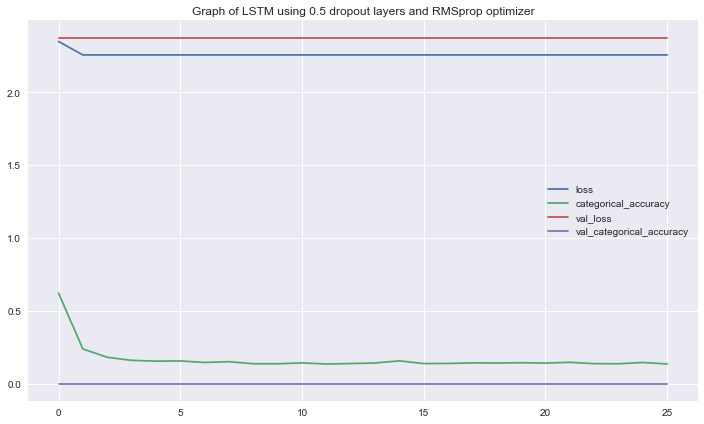

In [220]:
plt.style.use('seaborn')
losses3.plot(kind = 'line' , figsize=(12,7))
plt.title('Graph of LSTM using 0.5 dropout layers and RMSprop optimizer' )

Text(0.5, 1.0, 'Graph of LSTM using 0.5 dropout layers and SGD optimizer')

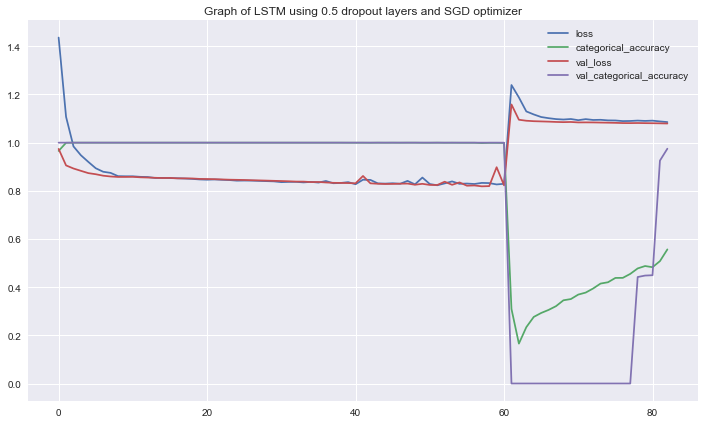

In [225]:
plt.style.use('seaborn')
losses3.plot(kind = 'line' , figsize=(12,7))
plt.title('Graph of LSTM using 0.5 dropout layers and SGD optimizer' )

Text(0.5, 1.0, 'Graph of LSTM using 0.5 dropout layers and Adam optimizer')

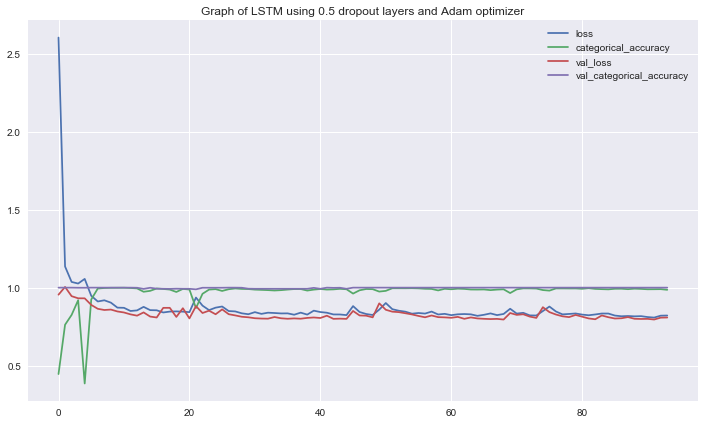

In [230]:
plt.style.use('seaborn')
losses3.plot(kind = 'line' , figsize=(12,7))
plt.title('Graph of LSTM using 0.5 dropout layers and Adam optimizer' )

* From the graphs above it is shown that the accuracy of LSTM model is high on Adam optimizer having learning rate 0.001
* All the other optimizer misbehaves on the accuracy like RMSprop and SGD optimizer

# Thank You